# **1. Multi-class Classification w/ Custom ResNet model**

⏺ Dataset : CIFAR10

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
# 런타임 유형 변경 - T4 GPU
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cu121  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:01<00:00, 97713753.22it/s] 


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [6]:
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


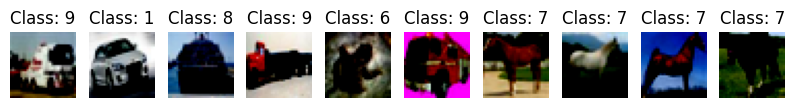

In [7]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1,10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [8]:
## Question 1
## Building custom ResNet model

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()   # shortcut을 빈 nn.Sequential로 초기화
        if stride != 1 or in_planes != planes:   # 입력과 출력의 차원이 다르거나, stride 가 1이 아닌 경우에 입출력 텐서를 일치시키기 위한 부분
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                #  shortcut을 통해서 conv 레이어를 건너뛰어서 출력에 직접 더하는 과정인데, 그 과정이 실행되기 위해서는 차원이 같아야하고
                #  그것을 가능하게 하기 위해서 kernel 사이즈가 1인 conv 레이어를 거치게 됩니다
                nn.BatchNorm2d(planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    # BasicBlock의 구조는 (conv1, bn1, relu), (conv2, bn2), shortcut을 더하고 나서 relu를 취한다.
    #                 in_planes --> planes --> planes --> + shortcut(planes) --> relu

class ResNet(nn.Module):
    def __init__(self, num_classes = 10): # class의 개수는 10개
        super(ResNet, self).__init__()
        self.in_planes = 16 # 입력 차원은 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1) # 16을 받아서 16으로 뱉는데 블록의 개수는 2개이고 첫 블록에서 차원을 줄이지 않는다.
        self.layer2 = self._make_layer(32, 2, stride = 2) # 16를 받아서 32로 뱉는데 블록의 개수는 2개이고 첫 블록에서만 차원을 줄인다.
        self.layer3 = self._make_layer(64, 2, stride = 2) # 32를 받아서 64로 뱉는데 블록의 개수는 2개이고 첫 블록에서만 차원을 줄인다.
        self.linear = nn.Linear(64, num_classes) # 64개 --> num_classes 인 fc

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1) # num_blocks 만큼 BasicBlock을 생성
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            # 정의된 in_planes와 입력받은 planes, stride에 따라서 BasicBlock을 만든다.
            self.in_planes = planes
            # 다음 블록을 실행하기에 앞서 차원을 맞추어주기 위한 코드
        return nn.Sequential(*layers) # BasicBlock 리스트를 풀어서 Sequential 컨테이너를 결과로 뱉는다.

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8) # average pooling으로 공간적인 차원을 줄이고
        out = out.view(out.size(0), -1) # 그러한 텐서를 flatten한다.
        out = self.linear(out) # 그 flatten된 텐서를 fc에 입력해서 결과를 출력
        return out

    # ResNet의 구조는 (conv1, bn1, relu), layer1(BasicBlock, BasicBlock), layer2(BasicBlock, BasicBlock), layer3(BasicBlock, BasicBlock), fc
    # dim :        3 --> 16 -----------> 16 ----------> 16 ---------> 16 ------------> 32 --------> 32 ---------------> 64 -------> 64 --> num_classes

### Question 1. Explain the code above (building custom ResNet model) in detail -- line-by-line recommended

In [9]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [10]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    # image, label, output 모두 텐서의 형태를 가진다.
    loss = criterion(output, label)
    # criterion 메서드는 텐서 연산을 통해서 출력값을 계산하기 때문에 출력값도 텐서의 형태를 가진다.
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item() # 그래서 이 부분에서 loss tensor를 스칼라만 뽑아서 출력하거나 계산에 활용한다.
      ))

In [11]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [12]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy)
  )

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.315920
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.588923
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.594113
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.637777
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.258975
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.041137
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.311025
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.372351

[EPOCH: 1], 	Test Loss: 1.0644, 	Test Accuracy: 61.57 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.120726
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.056068
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.853258
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.711652
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.934256
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.852798
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.258431
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.959221

[EPOCH: 2], 	Test Loss: 0.8358, 	Test Accuracy: 70.64 % 

## 2. Multi-class Classification w/ pre-trained ResNet model
*     Dataset: CIFAR10

### This chapter covers concepts and applications of Transfer learning. Then what's the tranfer learning? Google it and write your answer.

어떤 문제를 해결하는데 사용했던 네트워크를 다른 문제를 풀 때 활용하는 것을 의미하고 전이학습이라고 합니다. 대표적으로 ImageNet에서 학습시킨 CNN 네트워크를 다른 데이터셋에 대해서 활용하고자 할 때, 네트워크의 앞 부분에는 사전학습된 CNN 모델을 그대로 사용하고 뒷 부분에 fc 레이어를 추가해서 모델이 좀 더 학습을 빠르게 할 수 있습니다.

In [26]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [27]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print("Using PyTorch version:", torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cu121  Device: cuda


In [28]:
BATCH_SIZE = 32
EPOCHS = 10

In [29]:
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                 ]))
test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                ]))
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [30]:
for (X_train, y_train) in train_loader:
  print('X_train:',X_train.size(), 'type:', X_train.type())
  print('y_train:',y_train.size(), 'type:',y_train.type())
  break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [31]:
"""pltsize = 1
plt.figure(figsize = (30*pltsize, pltsize))

for i in range(10):
  for j in range(3):
    plt.subplot(1,30,i+j+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0))[:,:,j])
    plt.title('Class : ' + str(y_train[i].item()))"""

"pltsize = 1\nplt.figure(figsize = (30*pltsize, pltsize))\n\nfor i in range(10):\n  for j in range(3):\n    plt.subplot(1,30,i+j+1)\n    plt.axis('off')\n    plt.imshow(np.transpose(X_train[i], (1, 2, 0))[:,:,j])\n    plt.title('Class : ' + str(y_train[i].item()))"

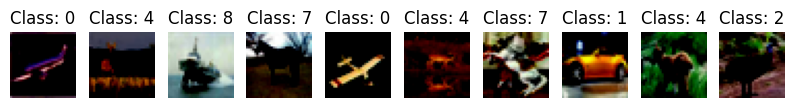

In [32]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [33]:
import torchvision.models as models
model = models.resnet34(pretrained = True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
## Important : There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
  parameter.requires_grad = False # We previously learned the requires_grad means utilizing backpropagation
# (2) Updating the weights of the pre-trained models
# for parameter in model.parameters():
#   parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate such CIFAR"10" issue, we should add one more layer having final 10 output nodes
model.fc = nn.Linear(num_ftrs, 10) # Add such layer!

model = model.cuda()

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()
      ))

In [37]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      criterion = nn.CrossEntropyLoss()
      test_loss = criterion(output, label)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [38]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy)
  )

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.707856
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.900121
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.764475
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.441135
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.740427
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.446797
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.105933
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.714079

[EPOCH: 1], 	Test Loss: 0.0043, 	Test Accuracy: 45.29 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.571460
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.810267
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.718523
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.631236
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.773934
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.326215
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.437698
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.751038

[EPOCH: 2], 	Test Loss: 0.0044, 	Test Accuracy: 45.08 % 

### Question 1. Compare & Contrast the test result (accuracy) of requires_grad = False & True.


### Question 2. Change the model ResNet34 to ResNet50 and run the entire code. Compare & Contrast the results of those two models.

### Question 3. Change the model ResNet34 to Inceptionv3 or v4 and run the entire code. Compare & Contrast the results of those two models.

# **Question 1**

In [39]:
import torchvision.models as models
model = models.resnet34(pretrained = True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
## Important : There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
  parameter.requires_grad = True # We previously learned the requires_grad means utilizing backpropagation
# (2) Updating the weights of the pre-trained models
# for parameter in model.parameters():
#   parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate such CIFAR"10" issue, we should add one more layer having final 10 output nodes
model.fc = nn.Linear(num_ftrs, 10) # Add such layer!

model = model.cuda()

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()
      ))

In [43]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      criterion = nn.CrossEntropyLoss()
      test_loss = criterion(output, label)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [44]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy)
  )

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.552652
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.073971
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.094469
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.032321
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.415987
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.909637
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.236319
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.941827

[EPOCH: 1], 	Test Loss: 0.0040, 	Test Accuracy: 65.73 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.904113
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.856652
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.574181
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.019735
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.584769
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.821763
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.548792
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.694543

[EPOCH: 2], 	Test Loss: 0.0028, 	Test Accuracy: 73.99 % 

# **Question 2**

In [45]:
import torchvision.models as models
model = models.resnet50(pretrained = True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
## Important : There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
  parameter.requires_grad = False # We previously learned the requires_grad means utilizing backpropagation
# (2) Updating the weights of the pre-trained models
# for parameter in model.parameters():
#   parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate such CIFAR"10" issue, we should add one more layer having final 10 output nodes
model.fc = nn.Linear(num_ftrs, 10) # Add such layer!

model = model.cuda()

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()
      ))

In [49]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      criterion = nn.CrossEntropyLoss()
      test_loss = criterion(output, label)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [50]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy)
  )

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.480851
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.589330
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.809680
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.511434
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.881397
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.705452
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.640089
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.891075

[EPOCH: 1], 	Test Loss: 0.0036, 	Test Accuracy: 47.50 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.902787
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.467422
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.773957
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.692191
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.087737
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.576569
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.719091
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.718715

[EPOCH: 2], 	Test Loss: 0.0034, 	Test Accuracy: 50.39 % 

# **Question 3**

In [51]:
import torchvision.models as models
model = models.Inception3(pretrained = True)
print(model)

TypeError: Inception3.__init__() got an unexpected keyword argument 'pretrained'

In [ ]:
## Important : There are 2 ways to use pre-trained models

# (1) NOT updating the weights of the pre-trained models, and use the model as it is
for parameter in model.parameters():
  parameter.requires_grad = False # We previously learned the requires_grad means utilizing backpropagation
# (2) Updating the weights of the pre-trained models
# for parameter in model.parameters():
#   parameter.requires_grad = True

# We usually use method #1 when using pre-trained models, but it's not the 100% perfect answer -- sometimes method #2 works better
# The optimal solution may vary according to the dataset or other techniques such as learning rate, optimizer, and so on

num_ftrs = model.fc.in_features # To mitigate such CIFAR"10" issue, we should add one more layer having final 10 output nodes
model.fc = nn.Linear(num_ftrs, 10) # Add such layer!

model = model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()
      ))

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      criterion = nn.CrossEntropyLoss()
      test_loss = criterion(output, label)
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy)
  )

## 3. Image Classification w/ pre-trained ResNet model -- custom dataset
*     Custom dataset: https://www.kaggle.com/datasets/jiweiliu/hymenoptera-data
*     Download the dataset and unzip it as always.

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
%cd /content/drive/MyDrive/codingstudy/assignment6

/content/drive/MyDrive/codingstudy/assignment6


In [75]:
!unzip archive.zip

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [76]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [77]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.deevice('cpu')

print('Using PyTorch version: ', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version:  2.2.1+cu121  Device:  cuda


In [78]:
BATCH_SIZE = 32
EPOCHS = 10

In [79]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val' : transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/codingstudy/assignment6/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, shuffle = True) for x in ['train', 'val']}

**### 이번 예제에서는 데이터셋과 데이터로더를 하나의 dictionary로 생성한 뒤에 key 값으로 구분하는 방식으로 생성하고 있다.**

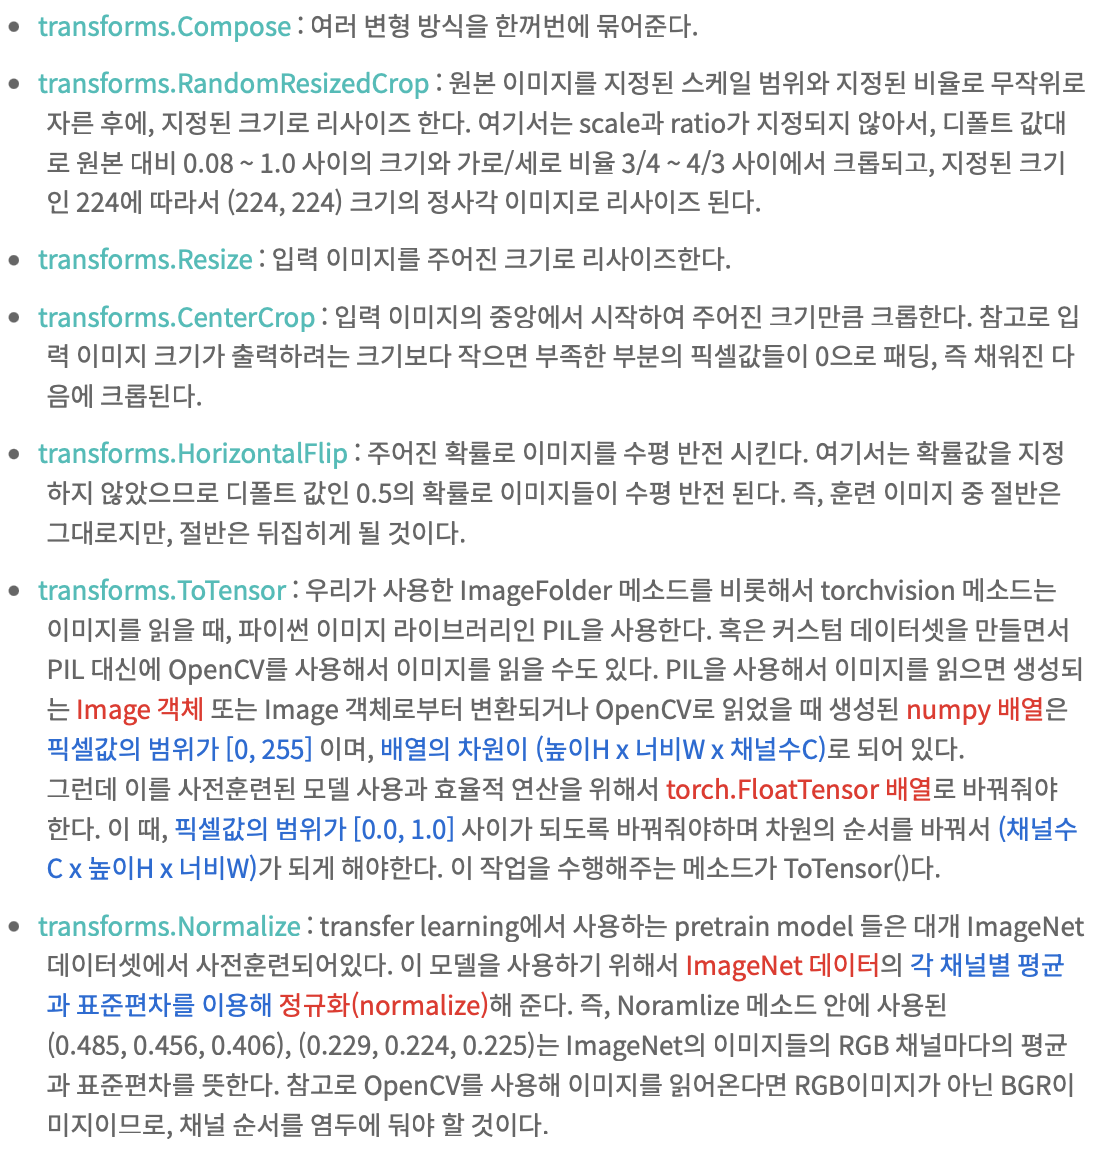

In [91]:
for (X_train, y_train) in dataloaders['train']:
  print('X_train: ', X_train.size(), 'type: ', X_train.type())
  print('y_train: ', y_train.size(), 'type: ', y_train.type())
  break

X_train:  torch.Size([32, 3, 224, 224]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


In [81]:
y_train

tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 0])

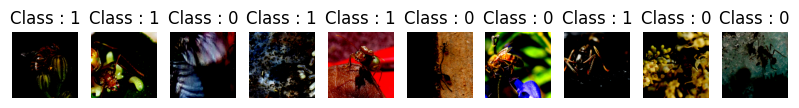

In [83]:
plt.size = 1
plt.figure(figsize = (10*pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1,2,0)))
  plt.title('Class : ' + str(y_train[i].item()))

In [84]:
import torchvision.models as models
model = models.resnet34(pretrained = True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [85]:
for parameter in model.parameters():
  parameter.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)

model = model.to(DEVICE)

In [86]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [87]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE, dtype = torch.float)
    label = label.to(DEVICE, dtype = torch.float)
    optimizer.zero_grad()
    output = model(image).squeeze(dim=1)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [88]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE, dtype = torch.float)
      label = label.to(DEVICE, dtype = torch.float)
      output = model(image).squeeze(dim = 1)
      test_loss += criterion(output, label.item())
      output1 = output.cpu()
      output1[output1 >= 0.5] = 1
      output1[output1 < 0.5] = 0
      correct += output1.eq(label.cpu()).int().sum()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [90]:
for epoch in range(1, EPOCHS + 1):
  train(model, dataloaders['train'], optimizer, log_interval = 5)
  valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, valid_loss, valid_accuracy)
  )

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.829510
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.611522
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.793824


RuntimeError: a Tensor with 32 elements cannot be converted to Scalar